In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import csv

In [2]:
#Read data set
file = open('sample_response_times.csv', mode='r')
csv_reader = csv.reader(file, delimiter=';')

data = []
for row in csv_reader:
	data.append(row)

data = np.array(data[1:], dtype=float)

print(np.mean([data[:,2] == 1.0][0]), np.mean([data[:,2] == 2.0][0]))


data = {
	'N': len(data),
	'y': data[:,0].astype(float),
	'condition':data[:,2].astype(int),
	'choice':data[:,1].astype(int),
}

data

0.5 0.5


{'N': 300,
 'y': array([0.477, 0.6  , 0.5  , 0.416, 0.435, 0.499, 0.531, 0.616, 0.492,
        0.682, 0.525, 0.714, 0.467, 1.106, 0.427, 0.681, 0.438, 0.584,
        0.461, 0.466, 0.488, 0.431, 0.501, 0.444, 0.496, 0.5  , 0.716,
        0.449, 0.45 , 0.552, 0.479, 0.497, 0.463, 0.54 , 0.44 , 0.425,
        0.554, 0.663, 0.434, 0.463, 0.423, 0.423, 0.45 , 0.687, 0.587,
        0.584, 0.531, 0.718, 0.534, 0.565, 0.43 , 0.505, 0.456, 0.668,
        0.459, 0.509, 0.506, 0.741, 0.633, 0.475, 0.635, 0.456, 0.466,
        0.567, 0.449, 0.451, 0.464, 0.467, 0.559, 0.425, 0.452, 0.411,
        0.528, 0.429, 0.521, 0.54 , 0.652, 0.687, 0.57 , 0.484, 0.545,
        0.479, 0.68 , 0.434, 0.458, 0.501, 0.509, 0.462, 0.452, 0.522,
        0.431, 0.43 , 0.49 , 0.697, 0.633, 0.539, 0.483, 1.11 , 0.472,
        0.757, 0.854, 0.653, 0.45 , 0.516, 0.547, 0.432, 0.483, 0.501,
        0.444, 0.515, 0.534, 0.441, 0.474, 0.513, 0.589, 0.446, 0.642,
        0.591, 0.64 , 0.449, 0.418, 0.615, 0.585, 0.459, 0.47

In [3]:
code = """
data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

parameters {
    // Your code here
	real<lower=0> alpha; 		// Boundary separation, assumed common across conditions for simplicity
	real<lower=0> beta;			// Starting position
    real v_easy; 				// Drift rate for the easy condition
    real v_difficult;			// Drift rate for the difficult condition
    real<lower=0> t; 			// Non-decision time, assumed common across conditions for simplicity
}

model {
    // Priors
    // Your code here
	alpha ~ gamma(3, 1);
	beta ~ beta(2, 2); 		// Starting point bias might be centered around 0.5 (no bias) with some variation
	v_easy ~ gamma(3, 1);
	v_difficult ~ gamma(3, 1);
	t ~ gamma(2, 1); // Non-decision time might reasonably fall within a specific range

    // Likelihood
    for (n in 1:N) {
        // Condition 1
        if (condition[n] == 1) {
            if (choice[n] == 1) {
            	y[n] ~ wiener(alpha, beta, t, v_easy);
            }
            else {
                y[n] ~ wiener(alpha, beta, t, -v_easy);
            }
        }
        // Condition 2
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                y[n] ~ wiener(alpha, beta, t, v_difficult);
            }
            else {
                y[n] ~ wiener(alpha, beta, t, -v_difficult);
            }
        }
    }
}
"""

In [4]:
model = stan.build(code,data)
fit = model.sample(num_chains=3,num_warmup=1000,num_samples=2500)

Building...

In file included from /Users/michaelchen/Library/Caches/httpstan/4.12.0/models/4rdqrgwu/model_4rdqrgwu.cpp:2:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/Eigen/SparseCore:61:
/opt/anaconda3/lib/python3.11/site-packages/httpstan/include/Eigen/src/SparseCore/TriangularSolver.h:273:13: warning: variable 'count' set but not used [-Wunused-but-set-variable]
      Index count = 0;
            ^
In file included from /Users/micha

ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: object file (/opt/anaconda3/lib/python3.11/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/opt/anaconda3/lib/python3.11/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11.0-arm64-cpython-311/Users/michaelchen/Library/Caches/httpstan/4.12.0/models/4rdqrgwu/model_4rdqrgwu.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/opt/anaconda3/lib/python3.11/site-packages/httpstan/s

In [ ]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,v_easy,v_difficult,t
draws,,,,,,,,,,,,
0,229.796091,0.999849,0.071856,5.0,31.0,0.0,-228.083823,1.418669,0.404004,1.846134,0.331078,0.787581
1,231.538601,0.998609,0.066822,4.0,31.0,0.0,-231.141393,1.964142,0.405273,2.062436,0.448817,0.840899
2,228.665569,0.998069,0.069064,4.0,15.0,0.0,-227.777156,1.356431,0.407638,1.653260,0.722113,0.789852
3,231.124807,0.999996,0.071856,5.0,31.0,0.0,-229.318920,1.534076,0.404587,1.843396,0.415350,0.805952
4,231.729985,0.955212,0.066822,6.0,63.0,0.0,-228.948375,3.722977,0.405114,1.810615,0.525197,0.918257


In [ ]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.695,1.114,1.213,4.870,0.029,0.023,1733.0,1910.0,1.0
beta,0.406,0.001,0.404,0.408,0.000,0.000,5679.0,4193.0,1.0
v_easy,2.012,0.243,1.566,2.472,0.004,0.003,4442.0,3908.0,1.0
v_difficult,0.480,0.167,0.167,0.783,0.003,0.002,4102.0,3637.0,1.0
t,0.875,0.045,0.796,0.953,0.001,0.001,1724.0,1904.0,1.0


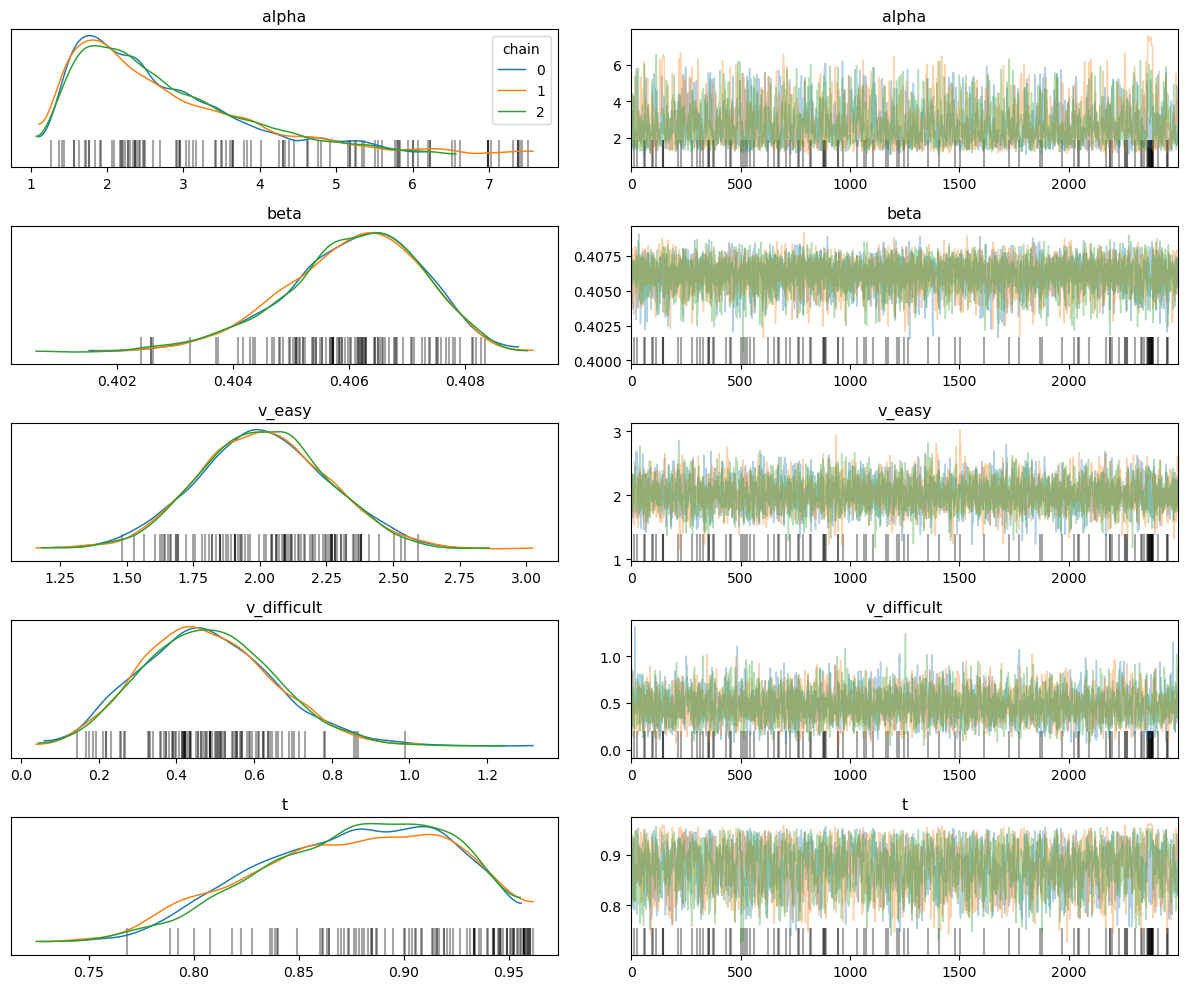

In [ ]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()